In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

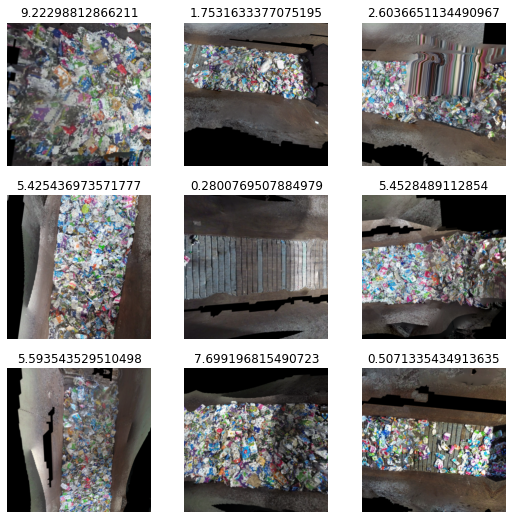

In [16]:
dls.show_batch()

In [15]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50Volumenv2')
]

In [16]:
from fastai.metrics import mae

In [17]:
learn = Learner(dls, timm.create_model('resnetrs50',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=mae,cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,9.671615,2.450417,1.131017,00:10


Better model found at epoch 0 with valid_loss value: 2.4504172801971436.


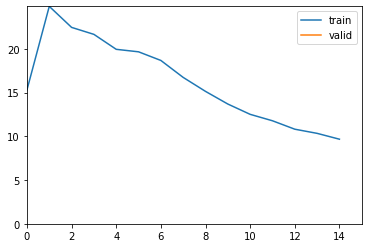

epoch,train_loss,valid_loss,mae,time
0,1.845608,1.711771,0.967967,00:06
1,1.485699,0.573533,0.574535,00:07
2,1.365190,1.224392,0.824515,00:07
3,1.217391,0.570750,0.574866,00:07
4,1.131294,0.478892,0.531424,00:07
5,1.020050,0.536926,0.523143,00:07
6,0.940783,0.359479,0.440331,00:07
7,0.854567,0.921959,0.649156,00:07
8,0.778929,0.435135,0.492646,00:07
9,0.744857,0.751679,0.629554,00:07


Better model found at epoch 0 with valid_loss value: 1.7117713689804077.


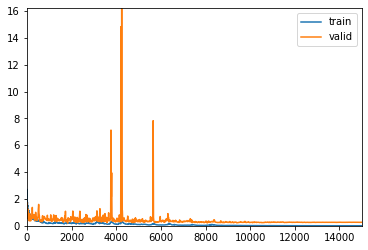

Better model found at epoch 1 with valid_loss value: 0.5735332369804382.
Better model found at epoch 3 with valid_loss value: 0.57075035572052.
Better model found at epoch 4 with valid_loss value: 0.478892058134079.
Better model found at epoch 6 with valid_loss value: 0.3594788908958435.
Better model found at epoch 40 with valid_loss value: 0.3067953288555145.
Better model found at epoch 44 with valid_loss value: 0.2971441149711609.
Better model found at epoch 108 with valid_loss value: 0.25954994559288025.
Better model found at epoch 120 with valid_loss value: 0.24063678085803986.
Better model found at epoch 121 with valid_loss value: 0.1990424543619156.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [18]:
learn.load('resnetrs50Volumenv2')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [19]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [20]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [21]:
dlstest = dbtest.dataloaders(path,bs=16)

In [22]:
learn.dls=dlstest

In [23]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.44397681951522827.


(#2) [0.690239429473877,0.44397681951522827]

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
preds,gt = learn.get_preds()

In [26]:
mean_absolute_error(gt,preds)

0.44397682

In [27]:
preds,gt = learn.tta()

In [28]:
mean_absolute_error(gt,preds)

0.4398506